# 1- Limpieza y creación de features

In [63]:
import pandas as pd

df = pd.read_csv("../data/comentarios_analizados.csv")

In [64]:
df.drop({"Unnamed: 0", "TOXICITY"}, axis=1, inplace=True)
df.rename({"text_x":"text"}, axis=1, inplace=True)

df.drop_duplicates(subset ='text', keep = False, inplace = True)
df = df.loc[df.canal != "Nimu"]


In [65]:
df.canal.value_counts()

NICO VILLA                313198
Romi                      212981
PassThor                  209330
Tincho Ruiz                90509
maritobaracus              73837
FFran Gomez                43708
Hecatombe Producciones     41661
AleVera Oficial            37155
Guille Aquino              32719
Rodriguez Galati           31112
Melina Vallejos            18171
SimpDNimu                    686
Name: canal, dtype: int64

Binarizo todo de acuerdo al threshold

In [66]:
toxicity_fields = [
    "toxicity",
    "THREAT_EXPERIMENTAL",
    "IDENTITY_ATTACK_EXPERIMENTAL",
    "INSULT_EXPERIMENTAL",
    "PROFANITY_EXPERIMENTAL",
    "SEVERE_TOXICITY",
]

engagement_fields = [
    'replyCount', 'likeCount', 'likes_video', 'vistas_video', 'cantidad_comentarios'
]

threshold = 0.8

df.loc[:, toxicity_fields] = df.loc[:, toxicity_fields] > threshold



Hasta acá, df es de comentarios, ahora con los valores binarizados.

Queremos un df por video 

Tomo la suma en el caso de los replyCounts y likeCounts (son a nivel comentario) y el primero para cada video

**CHEQUEAR ESTO!**

In [67]:
df_video = df.groupby("videoId").agg({
    **{k:"mean" for k in toxicity_fields},
    **{k:"sum" for k in ['replyCount', 'likeCount']},
    **{k:"first" for k in ['likes_video', 'vistas_video', 'cantidad_comentarios', 'canal']}
})

In [68]:
df_video["canal"].unique()

array(['Rodriguez Galati', 'NICO VILLA', 'maritobaracus', 'FFran Gomez',
       'AleVera Oficial', 'Tincho Ruiz', 'Romi', 'PassThor',
       'Hecatombe Producciones', 'Melina Vallejos', 'SimpDNimu',
       'Guille Aquino'], dtype=object)

In [69]:
import numpy as np

youtubers = df_video["canal"].unique()
zscore_fields = toxicity_fields

for field in zscore_fields:
    zscore_name = "z_" + field
    print(field)
    for youtuber in youtubers:
        values = df_video.loc[df_video["canal"] == youtuber, field]
        mean = values.mean()
        std = values.std()
        df_video.loc[df_video["canal"] == youtuber, zscore_name] = ((values - mean) / std).values

for field in engagement_fields:
    log_name = "log_" + field
    df_video[log_name] = np.log(df_video[field])
    


toxicity
THREAT_EXPERIMENTAL
IDENTITY_ATTACK_EXPERIMENTAL
INSULT_EXPERIMENTAL
PROFANITY_EXPERIMENTAL
SEVERE_TOXICITY


In [71]:
df_video.columns

Index(['toxicity', 'THREAT_EXPERIMENTAL', 'IDENTITY_ATTACK_EXPERIMENTAL',
       'INSULT_EXPERIMENTAL', 'PROFANITY_EXPERIMENTAL', 'SEVERE_TOXICITY',
       'replyCount', 'likeCount', 'likes_video', 'vistas_video',
       'cantidad_comentarios', 'canal', 'z_toxicity', 'z_THREAT_EXPERIMENTAL',
       'z_IDENTITY_ATTACK_EXPERIMENTAL', 'z_INSULT_EXPERIMENTAL',
       'z_PROFANITY_EXPERIMENTAL', 'z_SEVERE_TOXICITY', 'log_replyCount',
       'log_likeCount', 'log_likes_video', 'log_vistas_video',
       'log_cantidad_comentarios'],
      dtype='object')

In [75]:
column_order = [
    'replyCount', 'likeCount', 'likes_video', 'vistas_video',
    'cantidad_comentarios', 'canal', 'log_replyCount',
    'log_likeCount', 'log_likes_video', 'log_vistas_video',
    'log_cantidad_comentarios',
    'toxicity', 'THREAT_EXPERIMENTAL', 'IDENTITY_ATTACK_EXPERIMENTAL',
    'INSULT_EXPERIMENTAL', 'PROFANITY_EXPERIMENTAL', 'SEVERE_TOXICITY',
    'z_toxicity', 'z_THREAT_EXPERIMENTAL',
    'z_IDENTITY_ATTACK_EXPERIMENTAL', 'z_INSULT_EXPERIMENTAL',
    'z_PROFANITY_EXPERIMENTAL', 'z_SEVERE_TOXICITY', 
]

df_video = df_video.reindex(columns=column_order)

<AxesSubplot:>

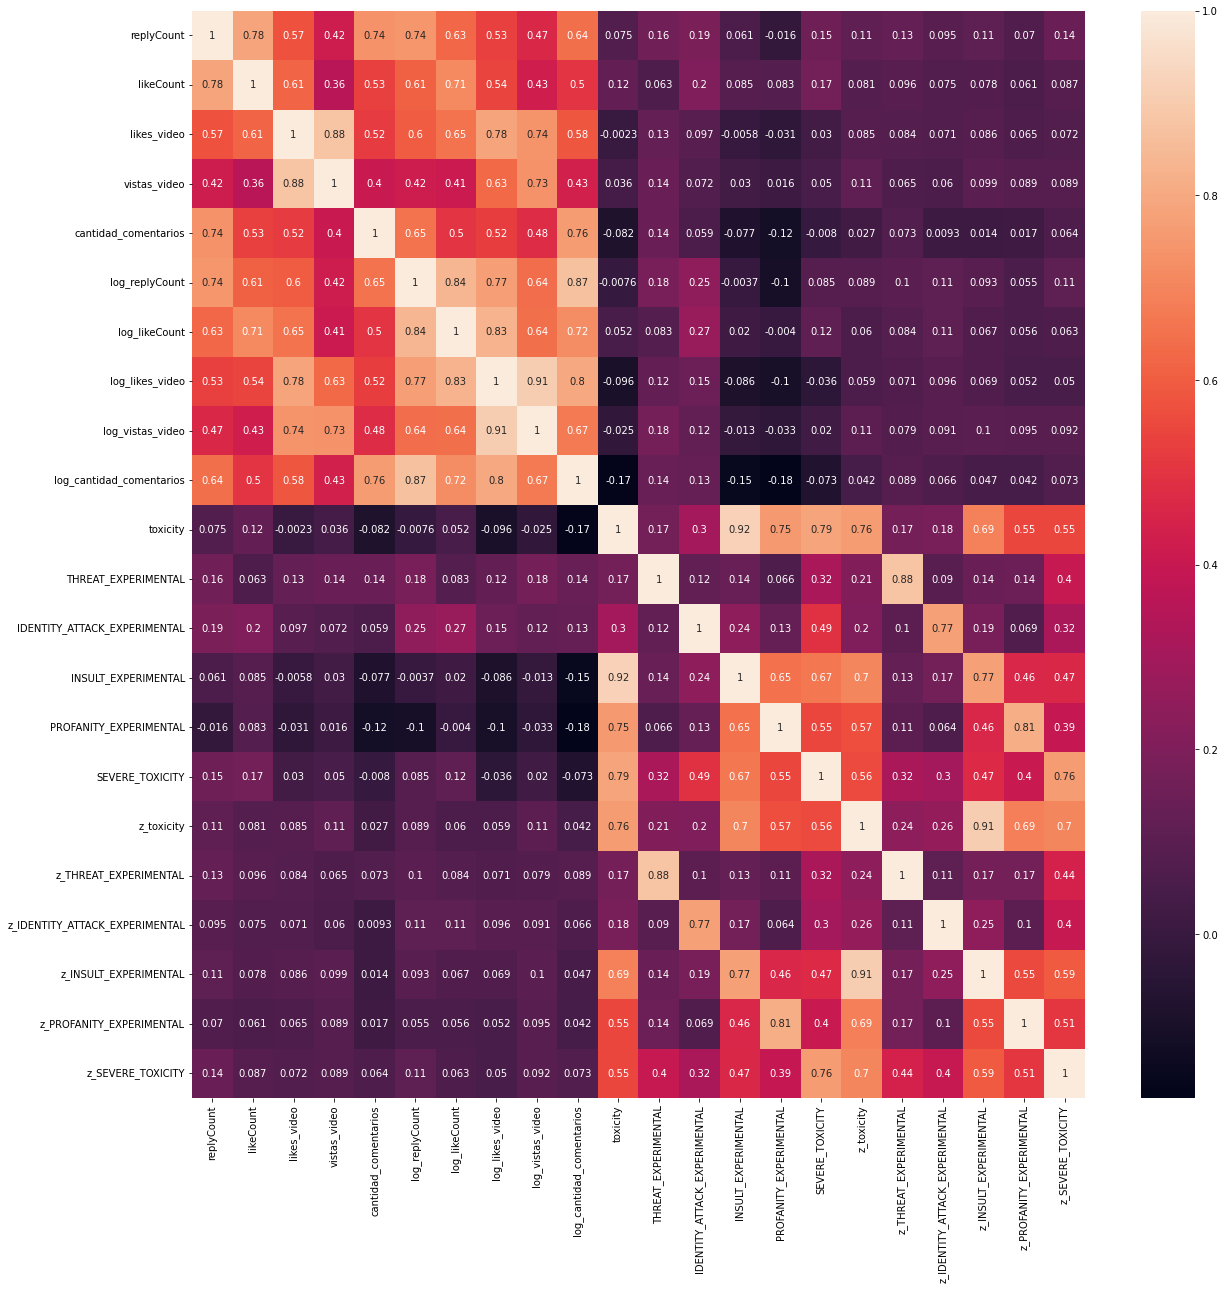

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(20,20))

sns.heatmap(data=df_video.corr(), annot=True)

## Cómicos

<AxesSubplot:>

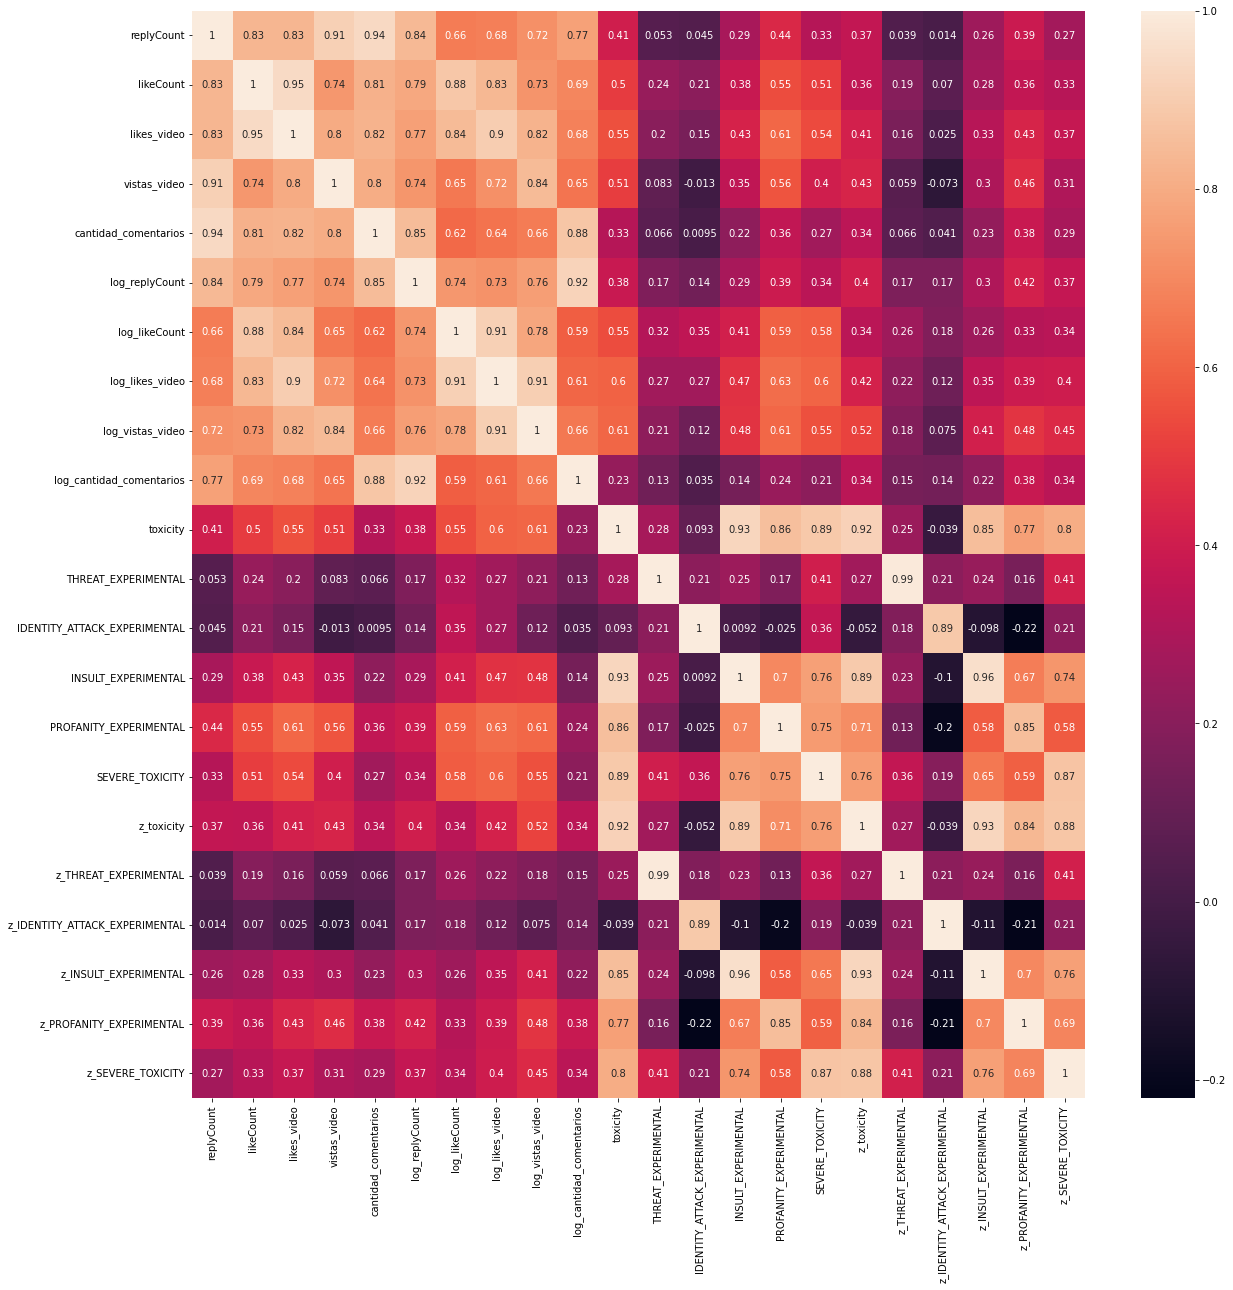

In [77]:
import matplotlib.pyplot as plt
import seaborn as sns
comicos = ["maritobaracus", 'AleVera Oficial', "Nimu"]

plt.figure(figsize=(20,20))

df_video_comicos = df_video.loc[df_video["canal"].isin(comicos)]

sns.heatmap(data=df_video_comicos.corr(), annot=True)

<AxesSubplot:>

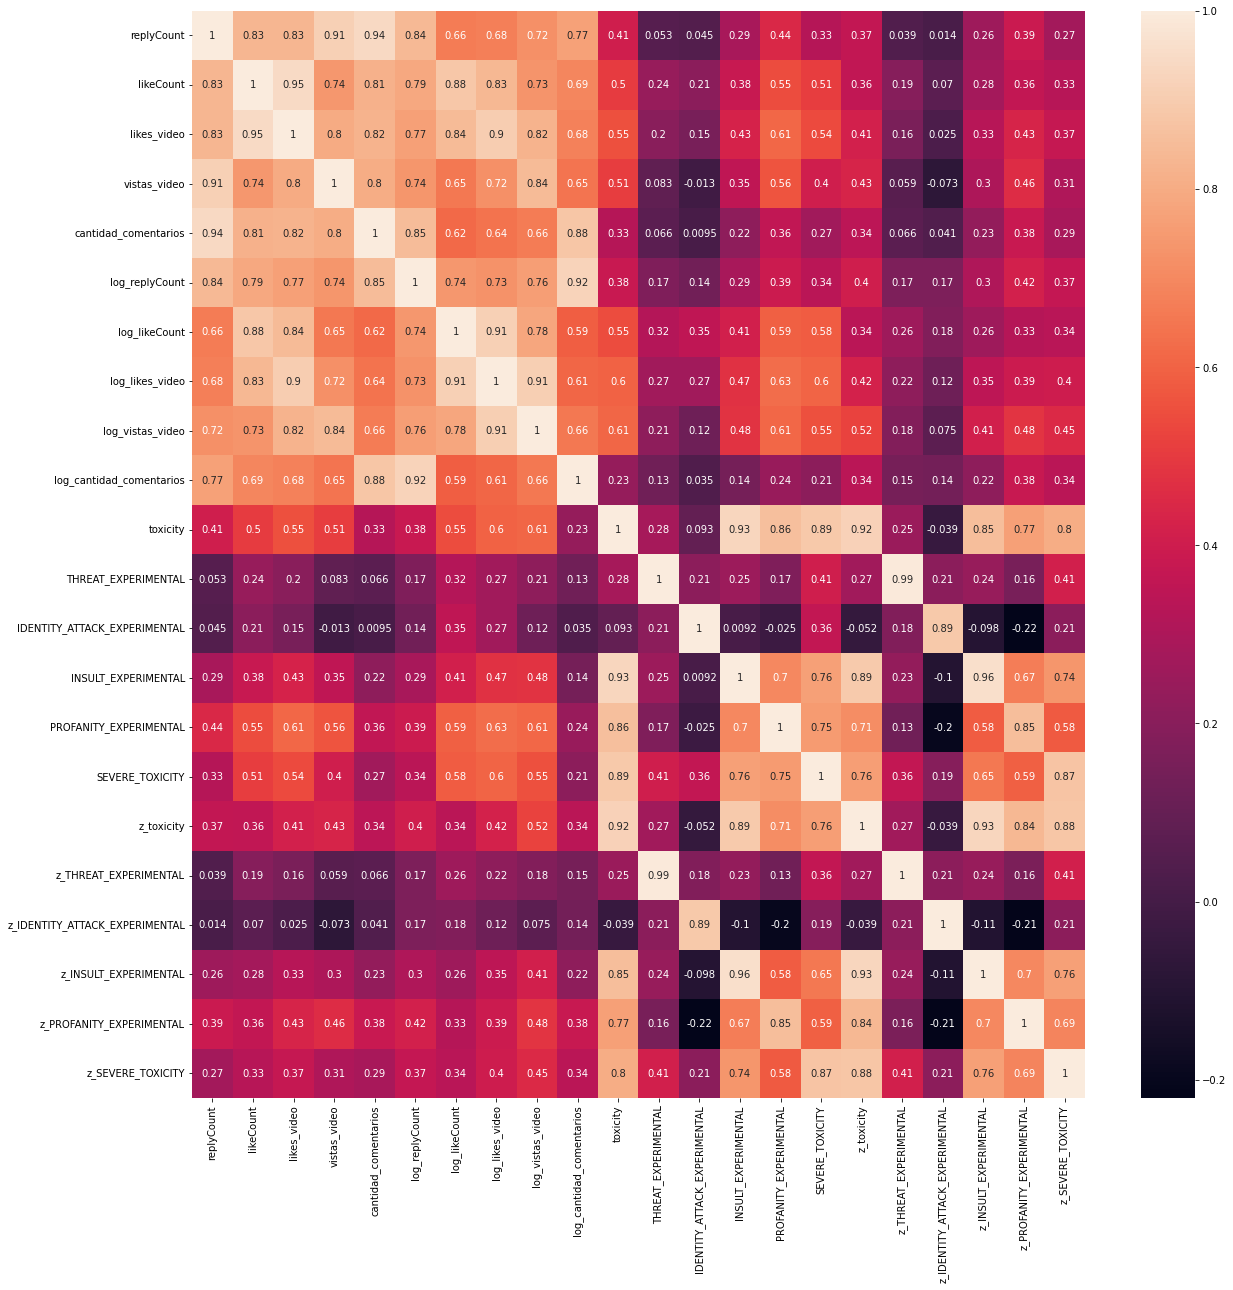

In [79]:

comicos = ["maritobaracus", 'AleVera Oficial']

plt.figure(figsize=(20,20))

df_video_comicos = df_video.loc[df_video["canal"].isin(comicos)]

sns.heatmap(data=df_video_comicos.corr(), annot=True)

In [80]:
from scipy.stats import pearsonr
import pandas as pd

def calculate_pvalues(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 6)
    return pvalues.astype(float)

<AxesSubplot:>

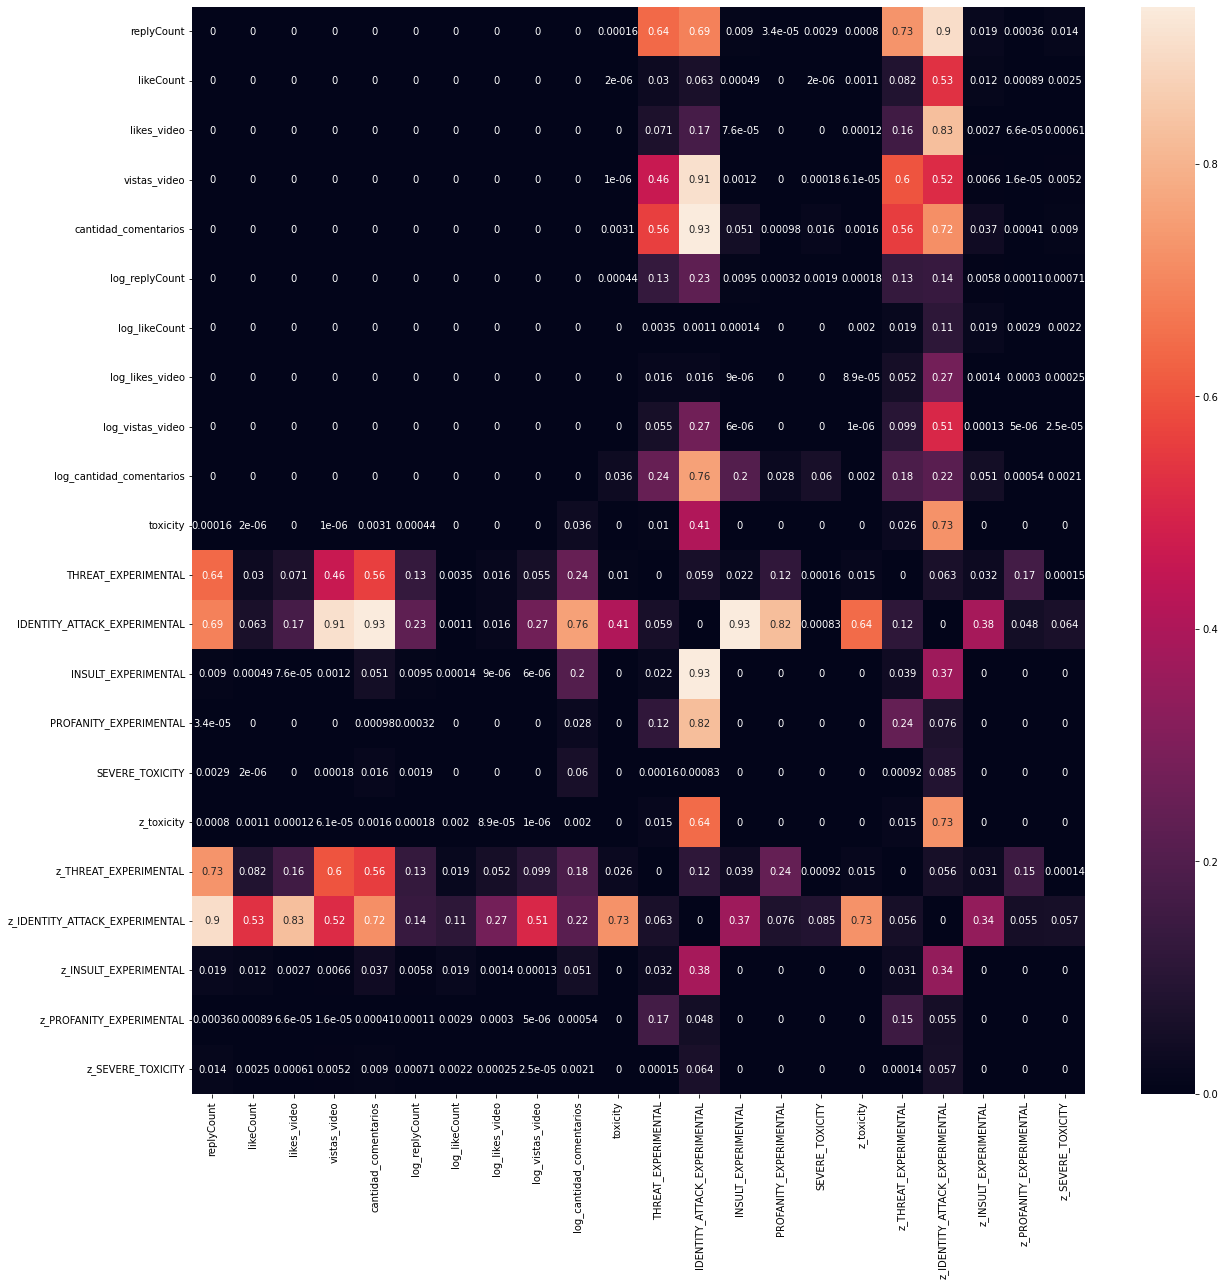

In [81]:

plt.figure(figsize=(20,20))


sns.heatmap(data=calculate_pvalues(df_video_comicos), annot=True)

## Efectos fijos

Agrego variables dummy para los efectos fijos por autor

In [82]:
data = df_video.copy()

autores = data.canal.value_counts().keys()

dummy_columns = [f"dummy_{canal}" for canal in autores]

for autor in autores:
    col_name = f"dummy_{autor}"
    data[col_name] = data.canal.apply(lambda x: 1 if x == autor else 0)

In [83]:
assert all(data.loc[:, dummy_columns].sum(axis=1) == 1)

In [84]:

import seaborn as sns
import matplotlib.pyplot as plt


toxicity_fields = [
    "toxicity",
    "THREAT_EXPERIMENTAL",
    "IDENTITY_ATTACK_EXPERIMENTAL",
    "INSULT_EXPERIMENTAL",
    "PROFANITY_EXPERIMENTAL",
    "SEVERE_TOXICITY",
]

engagement_fields = [
    'replyCount', 'likeCount', 'likes_video', 'vistas_video', 'cantidad_comentarios'
]

"""
for toxicity_field in toxicity_fields:
    for engagement_field in engagement_fields:
        plt.figure(figsize=(5,5))
        plt.semilogy()
        sns.scatterplot(y=engagement_field, x=toxicity_field, data=data, hue="canal")
"""

'\nfor toxicity_field in toxicity_fields:\n    for engagement_field in engagement_fields:\n        plt.figure(figsize=(5,5))\n        plt.semilogy()\n        sns.scatterplot(y=engagement_field, x=toxicity_field, data=data, hue="canal")\n'

Sin efectos fijos y sin log

In [85]:
import numpy as np
import statsmodels.api as sm


for toxicity_field in toxicity_fields:
    print("=" * 100)
    print(toxicity_field, "\n"*2)

    for engagement_field in engagement_fields:
        #print(f"log({engagement_field}) ~ {toxicity_field}")

        X = data[toxicity_field]
        X = sm.add_constant(X)
        y = data[engagement_field]
        model = sm.OLS(y, X)
        results = model.fit()

        #print(results.summary())
        print(f"{engagement_field:<25} slope {results.params.values[1]:6.3f} (pval = {results.pvalues.values[1]:.4f}, r2 = {results.rsquared:.4f})")
        

toxicity 


replyCount                slope 1457.236 (pval = 0.0317, r2 = 0.0057)
likeCount                 slope 75870.550 (pval = 0.0004, r2 = 0.0154)
likes_video               slope -3584.586 (pval = 0.9476, r2 = 0.0000)
vistas_video              slope 882003.903 (pval = 0.3067, r2 = 0.0013)
cantidad_comentarios      slope -8181.156 (pval = 0.0193, r2 = 0.0067)
THREAT_EXPERIMENTAL 


replyCount                slope 5228.763 (pval = 0.0000, r2 = 0.0271)
likeCount                 slope 63683.466 (pval = 0.0713, r2 = 0.0040)
likes_video               slope 333671.969 (pval = 0.0002, r2 = 0.0171)
vistas_video              slope 5722887.235 (pval = 0.0001, r2 = 0.0201)
cantidad_comentarios      slope 23190.213 (pval = 0.0001, r2 = 0.0200)
IDENTITY_ATTACK_EXPERIMENTAL 


replyCount                slope 6221.922 (pval = 0.0000, r2 = 0.0375)
likeCount                 slope 203380.357 (pval = 0.0000, r2 = 0.0401)
likes_video               slope 251063.502 (pval = 0.0056, r2 = 0.0095)
vistas_

Sin efectos fijos (con log engagement)

In [86]:
import numpy as np
import statsmodels.api as sm


for toxicity_field in toxicity_fields:
    print("=" * 100)
    print(toxicity_field, "\n"*2)

    for engagement_field in engagement_fields:
        #print(f"log({engagement_field}) ~ {toxicity_field}")

        X = data[toxicity_field]
        X = sm.add_constant(X)
        y = np.log(data[engagement_field])
        model = sm.OLS(y, X)
        results = model.fit()

        #print(results.summary())
        print(f"{engagement_field:<25} slope {results.params.values[1]:6.3f} (pval = {results.pvalues.values[1]:.4f}, r2 = {results.rsquared:.4f})")
        

toxicity 


replyCount                slope -0.454 (pval = 0.8295, r2 = 0.0001)
likeCount                 slope  3.581 (pval = 0.1423, r2 = 0.0027)
likes_video               slope -4.523 (pval = 0.0061, r2 = 0.0092)
vistas_video              slope -1.182 (pval = 0.4837, r2 = 0.0006)
cantidad_comentarios      slope -9.100 (pval = 0.0000, r2 = 0.0294)
THREAT_EXPERIMENTAL 


replyCount                slope 18.153 (pval = 0.0000, r2 = 0.0339)
likeCount                 slope  9.460 (pval = 0.0184, r2 = 0.0069)
likes_video               slope  9.534 (pval = 0.0004, r2 = 0.0152)
vistas_video              slope 13.887 (pval = 0.0000, r2 = 0.0309)
cantidad_comentarios      slope 12.155 (pval = 0.0001, r2 = 0.0194)
IDENTITY_ATTACK_EXPERIMENTAL 


replyCount                slope 24.639 (pval = 0.0000, r2 = 0.0612)
likeCount                 slope 31.546 (pval = 0.0000, r2 = 0.0746)
likes_video               slope 11.497 (pval = 0.0000, r2 = 0.0216)
vistas_video              slope  9.567 (pval = 0.

Con efectos fijos

In [87]:
import numpy as np
import statsmodels.api as sm


for toxicity_field in toxicity_fields:
    print("=" * 100)
    print(toxicity_field, "\n"*2)

    for engagement_field in engagement_fields:
        #print(f"log({engagement_field}) ~ {toxicity_field}")

        X = data[[toxicity_field] + dummy_columns]
        y = np.log(data[engagement_field])
        model = sm.OLS(y, X)
        results = model.fit()

        #print(results.summary())
        print(f"{engagement_field:<25} slope {results.params.values[1]:6.3f} (pval = {results.pvalues.values[1]:.4f}, r2 = {results.rsquared:.4f})")
        

toxicity 


replyCount                slope  4.820 (pval = 0.0000, r2 = 0.4643)
likeCount                 slope  7.244 (pval = 0.0000, r2 = 0.4530)
likes_video               slope 10.164 (pval = 0.0000, r2 = 0.3478)
vistas_video              slope 13.003 (pval = 0.0000, r2 = 0.2685)
cantidad_comentarios      slope  7.139 (pval = 0.0000, r2 = 0.4773)
THREAT_EXPERIMENTAL 


replyCount                slope  4.740 (pval = 0.0000, r2 = 0.4641)
likeCount                 slope  7.153 (pval = 0.0000, r2 = 0.4547)
likes_video               slope 10.131 (pval = 0.0000, r2 = 0.3473)
vistas_video              slope 12.988 (pval = 0.0000, r2 = 0.2635)
cantidad_comentarios      slope  7.032 (pval = 0.0000, r2 = 0.4821)
IDENTITY_ATTACK_EXPERIMENTAL 


replyCount                slope  4.861 (pval = 0.0000, r2 = 0.4654)
likeCount                 slope  7.232 (pval = 0.0000, r2 = 0.4600)
likes_video               slope 10.168 (pval = 0.0000, r2 = 0.3513)
vistas_video              slope 13.055 (pval = 0.